In [1]:
import os
from pathlib import Path
import sys

# ==============================================================================
# Set up the PDK Environment
# ==============================================================================
def setup_pdk_environment():
    """
    Sets the PDK_ROOT environment variable so glayout can find the PDKs.
    """
    # Define the path to your volare-managed PDKs
    pdk_root_path = "~/.volare"
    
    # Expand the user home directory (e.g., '~') to get the full path
    pdk_root_expanded = Path(pdk_root_path).expanduser()

    # Check if the volare directory actually exists
    if not pdk_root_expanded.is_dir():
        print(f"❌ ERROR: The specified PDK_ROOT path does not exist.")
        print(f"   Checked Path: {pdk_root_expanded}")
        print(f"   Please ensure volare is installed and has downloaded PDKs.")
        sys.exit(1)

    # Set the environment variable. This is the crucial step.
    os.environ['PDK_ROOT'] = str(pdk_root_expanded)
    print(f"✅ PDK_ROOT set to: {os.environ['PDK_ROOT']}")

# --- Run the setup function immediately ---
setup_pdk_environment()

✅ PDK_ROOT set to: /home/irman/.volare


In [2]:
from glayout import sky130, gf180
from glayout.primitives.via_gen import via_stack, via_array
from glayout.primitives.fet import nmos, pmos, multiplier
from glayout.primitives.guardring import tapring
from glayout.util.port_utils import PortTree, rename_ports_by_orientation
from glayout.util.comp_utils import move, movex, movey, align_comp_to_port, evaluate_bbox, prec_center
from glayout.routing.straight_route import straight_route
from glayout.routing.c_route import c_route
from gdsfactory import Component
import gdstk
import svgutils.transform as sg
import IPython.display
from IPython.display import clear_output
import ipywidgets as widgets

# Redirect all outputs here
hide = widgets.Output()

def display_gds(gds_file, scale = 3):
  # Generate an SVG image
  top_level_cell = gdstk.read_gds(gds_file).top_level()[0]
  top_level_cell.write_svg('out.svg')
  # Scale the image for displaying
  fig = sg.fromfile('out.svg')
  fig.set_size((str(float(fig.width) * scale), str(float(fig.height) * scale)))
  fig.save('out.svg')

  # Display the image
  IPython.display.display(IPython.display.SVG('out.svg'))

def display_component(component, scale = 3):
  # Save to a GDS file
  with hide:
    component.write_gds("out.gds")
  display_gds('out.gds', scale)

2025-08-28 14:40:57.462 | INFO     | gdsfactory.pdk:activate:337 - 'gf180' PDK is now active
/tmp/ipykernel_503046/2400741529.py:18: UserWarning: Unnamed cells, 4 in 'Unnamed_15fc5766'
  currentMirror(gf180).write_gds("cmirror_example.gds")
2025-08-28 14:41:00.176 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to 'cmirror_example.gds'


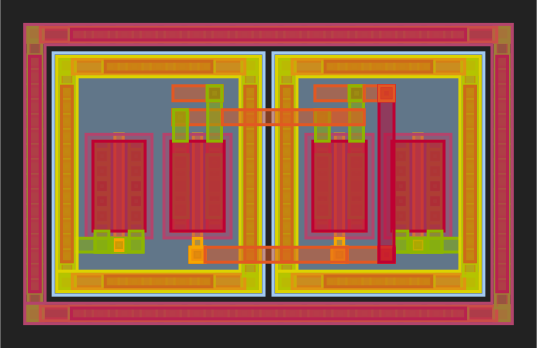

In [3]:
def currentMirror(pdk):
  currMirrComp = Component()
  pfet_ref = pmos(pdk, with_substrate_tap=False, with_dummy=(False, True))
  pfet_mir = pmos(pdk, with_substrate_tap=False, with_dummy=(True, False))
  cref_ref = currMirrComp << pfet_ref
  cmir_ref = currMirrComp << pfet_mir
  pdk.util_max_metal_seperation()
  cref_ref.movex(evaluate_bbox(pfet_mir)[0] + pdk.util_max_metal_seperation())
  tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(currMirrComp.flatten(), padding=pdk.get_grule("nwell", "active_diff")["min_enclosure"]))
  shift_amount = -prec_center(currMirrComp.flatten())[0]
  tring_ref = currMirrComp << tap_ring
  tring_ref.movex(destination=shift_amount)
  currMirrComp << straight_route(pdk, cref_ref.ports["multiplier_0_source_E"], cmir_ref.ports["multiplier_0_source_E"])
  currMirrComp << straight_route(pdk, cref_ref.ports["multiplier_0_gate_E"], cmir_ref.ports["multiplier_0_gate_E"])
  currMirrComp << c_route(pdk, cref_ref.ports["multiplier_0_gate_E"], cref_ref.ports["multiplier_0_drain_E"])
  return currMirrComp

currentMirror(gf180).write_gds("cmirror_example.gds")
display_gds("cmirror_example.gds")